In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
df = pd.read_csv('data/forestfires.csv')

In [51]:
df = df.drop(df[df.FFMC < 80].index)  # dropping outliers

In [91]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [92]:
train_df = df[[_ for _ in df.columns if _ != 'area']]

In [93]:
days_ohe = OneHotEncoder()
days_encoded = pd.DataFrame(days_ohe.fit_transform(df.day.values.reshape(-1, 1)).todense().astype(int), dtype=int)
days_encoded.columns = days_ohe.categories_[0]

In [94]:
month_ohe = OneHotEncoder()
month_encoded = pd.DataFrame(month_ohe.fit_transform(df.month.values.reshape(-1, 1)).todense().astype(int), dtype=int)
month_encoded.columns = month_ohe.categories_[0]

In [95]:
train_df = pd.concat([train_df[[_ for _ in train_df.columns if _ not in ['day', 'month']]], days_encoded, month_encoded], axis=1)

In [133]:
train_df = train_df.dropna()

In [134]:
X_train, X_test, y_train, y_test = train_test_split(train_df, df.area[train_df.index], random_state=100)

In [139]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=250)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

In [140]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

-0.46692855288285684

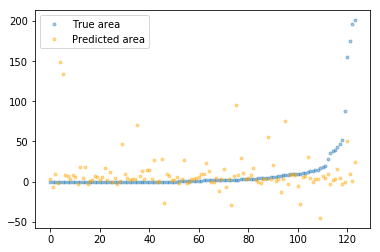

In [142]:
def compare(y_test, y_pred):
    s_idx = np.argsort(y_test)
    s = y_test.values[s_idx]
    idx = np.arange(len(s), dtype=int)
    plt.plot(idx, s, marker='.', linewidth=0, alpha=0.4, label='True area');
    plt.plot(idx, y_pred[s_idx], marker='.', c='orange', alpha=0.4, linewidth=0, label='Predicted area');
    plt.legend();
compare(y_test, y_pred)

In [143]:
from sklearn.linear_model import RidgeCV

In [144]:
rcv = RidgeCV()
rcv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [145]:
y_pred = rcv.predict(X_test)
r2_score(y_test, y_pred)

-0.1765977552316056

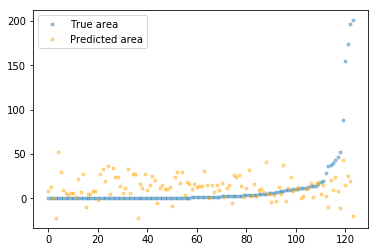

In [146]:
compare(y_test, y_pred)

In [147]:
# As we see, it really performs poorly

# Now let's try log transform on target variable
from sklearn.preprocessing import FunctionTransformer
TRAINsformer = FunctionTransformer(np.log1p, validate=False)
reverse_transform = FunctionTransformer(np.exp, validate=False)
y_transformed = TRAINsformer.transform(y_train)


In [148]:
y_test_transformed = TRAINsformer.transform(y_test)

In [149]:
from sklearn.preprocessing import StandardScaler

In [150]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [151]:
rcv_tf = RidgeCV()  # Cross-validated Ridge regression
rcv_tf.fit(X_train, y_transformed)
y_pred = rcv_tf.predict(X_test)

In [152]:
y_pred = reverse_transform.transform(y_pred)

In [153]:
r2_score(y_test, y_pred)

-0.07272442129673418

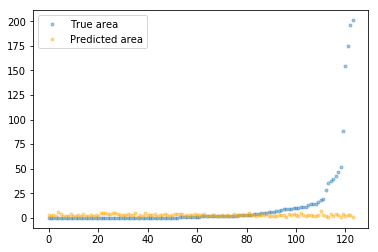

In [154]:
compare(y_test, y_pred)

In [159]:
from sklearn.linear_model import ElasticNetCV
enet = ElasticNetCV(cv=5)
enet.fit(X_train, y_transformed)
y_pred = reverse_transform.transform(enet.predict(X_test))

In [160]:
r2_score(y_test, y_pred)

-0.06417351148569139

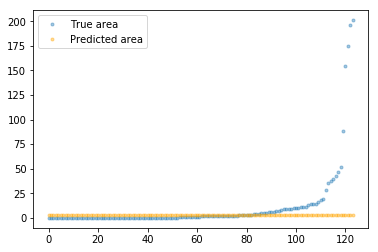

In [161]:
compare(y_test, y_pred)